**Project 2**  
*MODELING TRAFFIC FLOW*  
MOD600  
*Urszula Maria Starowicz*  


In [102]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt

Task 2.1 *d*  
#### Solve an example
$$ f(u) = \frac{1}{4} u^2 $$
for:
$$
u_0(x) =
\begin{cases} 
2x, & \text{if } 0\leq x\leq \frac{1}{2}\\ 
1, & \text{if } \frac{1}{2} < x \leq 1\\
3-2x, & \text{if } 1<x \leq \frac{3}{2}
\end{cases}
$$
*Exact solution:*

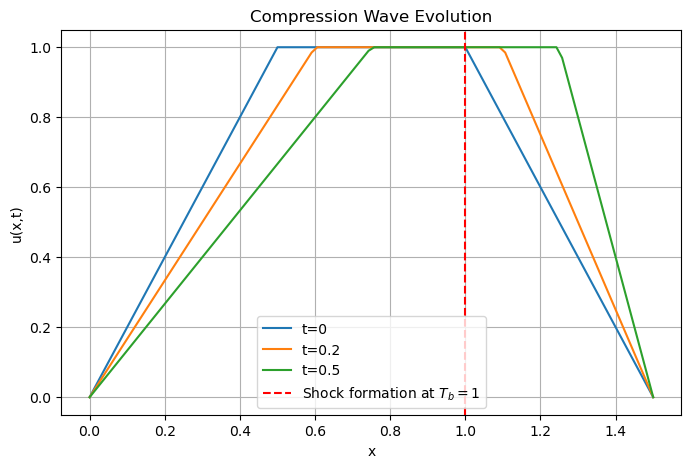

In [103]:
# Define initial function u_0(x)
def u_0(x):
    return np.piecewise(
        x,
        [((x >= 0) & (x <= 0.5)), ((x > 0.5) & (x <= 1)), ((x > 1) & (x <= 1.5))],
        [lambda x: 2 * x, 1, lambda x: 3 - 2 * x]
    )

# Solve for characteristic foot x_0 implicitly
def x_0(x, t):
    """ Finds the characteristic origin x_0 for given x and t """
    from scipy.optimize import fsolve
    # Define implicit equation for x_0
    func = lambda x0: x0 + 0.5 * u_0(x0) * t - x
    x0_guess = x  # Initial guess
    x0_sol = fsolve(func, x0_guess)
    return x0_sol[0]

# Compute exact solution using characteristics or shock tracking
def u_exact(x, t):
    if t == 0:
        return u_0(x)

    # Compute characteristic foot
    x0 = x_0(x, t)

    # Find u(x,t) based on initial profile
    u_value = u_0(x0)

    # Check for shock formation
    if t > 0.5:  # Shock appears around t ≈ 0.5
        if x > 1:  # Shock propagates from x = 1
            return 1  # Constant state in the shocked region
        else:
            return u_value  # Follow the characteristic solution

    return u_value

# Create grid
x_values = np.linspace(0, 1.5, 100)
t_values = [0, 0.2, 0.5]  # Different time steps

# Plot results
plt.figure(figsize=(8, 5))
for t in t_values:
    u_values = np.array([u_exact(x, t) for x in x_values])
    plt.plot(x_values, u_values, label=f"t={t}")

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.axvline(x=1, linestyle="--", color="red", label="Shock formation at $T_b=1$")
plt.title("Compression Wave Evolution")
plt.grid()
plt.legend()
plt.show()


*Numerical solution using Rusanov scheme:*

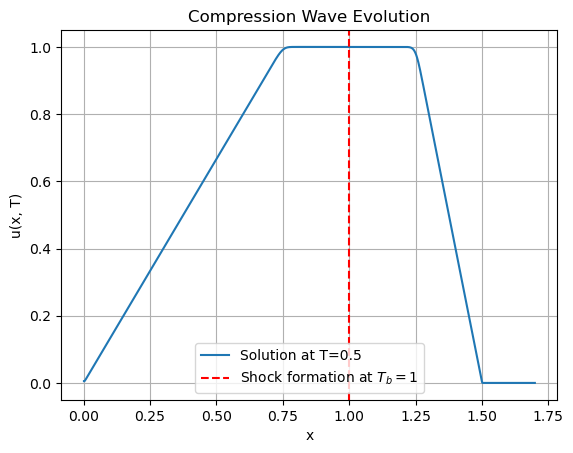

In [104]:
def flux(u):
    return 0.25 * u**2  # f(u) = (1/4) * u^2

def flux_derivative(u):
    return 0.5 * u  # f'(u) = (1/2) * u

def initial_condition(x):
    u0 = np.piecewise(x, 
                       [x < 0.5, (x >= 0.5) & (x <= 1), (x > 1) & (x <= 1.5)],
                       [lambda x: 2*x, 1, lambda x: 3 - 2*x])
    return u0

def rusanov_flux(ul, ur):
    f_ul, f_ur = flux(ul), flux(ur)
    max_speed = max(abs(flux_derivative(ul)), abs(flux_derivative(ur)))
    return 0.5 * (f_ul + f_ur) - 0.5 * max_speed * (ur - ul)

def solve_rusanov(xmin, xmax, Nx, T, CFL=0.5):
    dx = (xmax - xmin) / Nx  # Space step
    x = np.linspace(xmin + dx/2, xmax - dx/2, Nx)  # Cell-centered grid
    u = initial_condition(x)  # Initial condition

    dt = CFL * dx / np.max(np.abs(flux_derivative(u)))  # Time step based on CFL
    Nt = int(T / dt)  # Number of time steps
    dt = T / Nt  # Adjust dt to match T exactly

    for _ in range(Nt):
        f_half = np.zeros(Nx + 1)
        for i in range(Nx - 1):
            f_half[i+1] = rusanov_flux(u[i], u[i+1])

        u[1:-1] -= dt / dx * (f_half[2:Nx] - f_half[1:Nx-1])
        u[0] = u[1]  # Outflow boundary condition
        u[-1] = u[-2]

    return x, u

# Define parameters
xmin, xmax = 0, 1.7
Nx = 1000  # Number of grid points
T = 0.5  # Final time

x, u = solve_rusanov(xmin, xmax, Nx, T)

# Plot the results
plt.plot(x, u, label=f"Solution at T={T}")
plt.xlabel("x")
plt.ylabel("u(x, T)")
plt.axvline(x=1, linestyle="--", color="red", label="Shock formation at $T_b=1$")
plt.title("Compression Wave Evolution")
plt.legend()
plt.grid()
plt.show()

# Create grid
x_values = np.linspace(0, 1.5, 100)
t_values = [0.5]  # Different time steps


*Comparision between exact and numerical solution:*

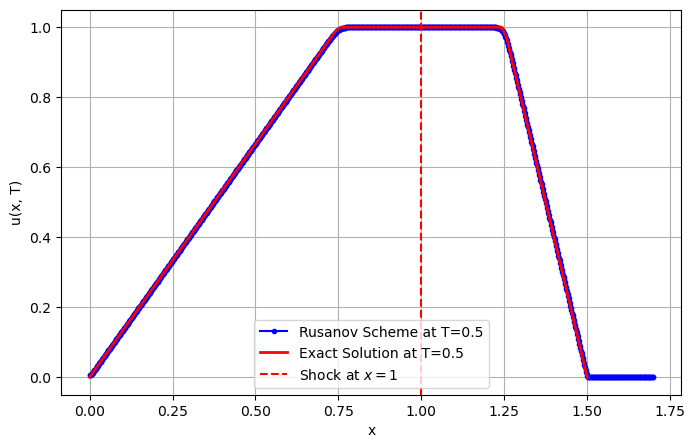

In [105]:
# Define initial function u_0(x)
def u_0(x):
    return np.piecewise(
        x,
        [((x >= 0) & (x <= 0.5)), ((x > 0.5) & (x <= 1)), ((x > 1) & (x <= 1.5))],
        [lambda x: 2 * x, 1, lambda x: 3 - 2 * x]
    )

# Solve for characteristic foot x_0 implicitly
def x_0(x, t):
    """ Finds the characteristic origin x_0 for given x and t """
    from scipy.optimize import fsolve
    func = lambda x0: x0 + 0.5 * u_0(x0) * t - x
    x0_guess = x  # Initial guess
    x0_sol = fsolve(func, x0_guess)
    return x0_sol[0]

# Parameters
xmin, xmax, Nx, T = 0, 1.5, 100, 0.5

# Solve Rusanov scheme
x_rusanov, u_rusanov = solve_rusanov(xmin, xmax, Nx, T)

# Create grid for exact solution
x_exact = np.linspace(xmin, xmax, 100)
u_exact_values = np.array([u_exact(x, T) for x in x_exact])

# Plot both solutions
plt.figure(figsize=(8, 5))
plt.plot(x, u, 'bo-', markersize=3, label="Rusanov Scheme at T=0.5")
plt.plot(x_exact, u_exact_values, 'r-', linewidth=2, label="Exact Solution at T=0.5")

plt.xlabel("x")
plt.ylabel("u(x, T)")
plt.axvline(x=1, linestyle="--", color="red", label="Shock at $x=1$")
plt.legend()
plt.grid()
plt.show()


*Characteristics lines:*

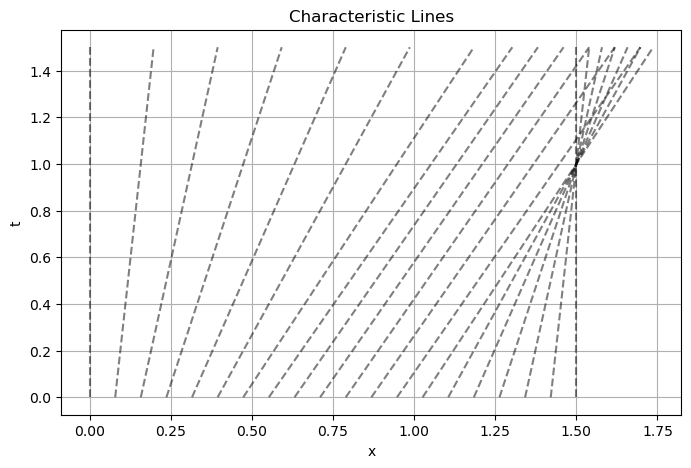

In [106]:
plt.figure(figsize=(8, 5))

t_char = np.linspace(0, 1.5, 50)  # Time values for characteristics
x0_values = np.linspace(0, 1.5, 20)  # Starting points for characteristics

for x0 in x0_values:
    u0 = u_0(x0)
    if u0 is not None:
        x_char = x0 + 0.5 * u0 * t_char  # Characteristic equation
        plt.plot(x_char, t_char, 'k--', alpha=0.5)  # Dashed characteristic lines

plt.xlabel("x")
plt.ylabel("t")
plt.title("Characteristic Lines")
plt.grid()
plt.show()

*Formula to get an insight into when a discontinuity takes place:*

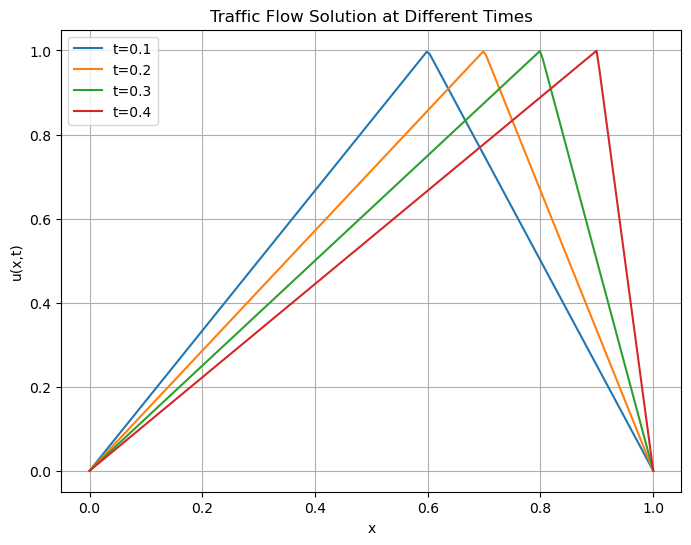

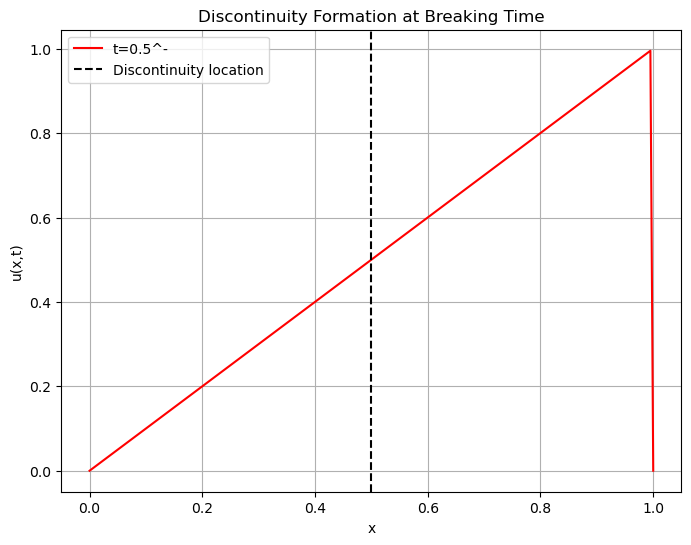

In [107]:
def u_initial(x):
    """Initial condition function."""
    return np.where(x <= 0.5, 2*x, 2*(1-x))

def u_solution(x, t):
    """Solution function assuming no discontinuity formation."""
    x0_left = x / (1 + 2*t)
    x0_right = (x - 2*t) / (1 - 2*t)
    
    u = np.zeros_like(x)
    mask_left = (x0_left >= 0) & (x0_left <= 0.5)
    mask_right = (x0_right > 0.5) & (x0_right <= 1)
    
    u[mask_left] = 2 * x0_left[mask_left]
    u[mask_right] = 2 * (1 - x0_right[mask_right])
    
    return u

def plot_different_times(times, x_range):
    """Plot solution at different times."""
    x = np.linspace(*x_range, 200)
    plt.figure(figsize=(8, 6))
    
    for t in times:
        u = u_solution(x, t)
        plt.plot(x, u, label=f't={t}')
    
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title('Traffic Flow Solution at Different Times')
    plt.legend()
    plt.grid()
    plt.show()

def plot_discontinuity(x_range):
    """Plot the discontinuity formation at breaking time."""
    x = np.linspace(*x_range, 200)
    t_break = 0.5  # Discontinuity forms at t = 1/2
    u = u_solution(x, t_break - 1e-3)  # Just before discontinuity
    
    plt.figure(figsize=(8, 6))
    plt.plot(x, u, label=f't={t_break}^-', color='r')
    plt.axvline(0.5, linestyle='--', color='k', label='Discontinuity location')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title('Discontinuity Formation at Breaking Time')
    plt.legend()
    plt.grid()
    plt.show()

# Define the time instances and x-range to visualize the solutions
times = [0.1, 0.2, 0.3, 0.4]
x_range = (0, 1)

plot_different_times(times, x_range)
plot_discontinuity(x_range)


Task 2.1 *e*  
#### Solve the given Riemann problem

$$
f(u) = 2u(1 - u)
$$

with initial data:

$$
u_0(x) =
\begin{cases} 
0, & \text{if } x < 0\\ 
\frac{3}{4}, & \text{if } x \in [0,1]\\ 
0, & \text{if } x > 1
\end{cases}
$$

*Exact solution:*

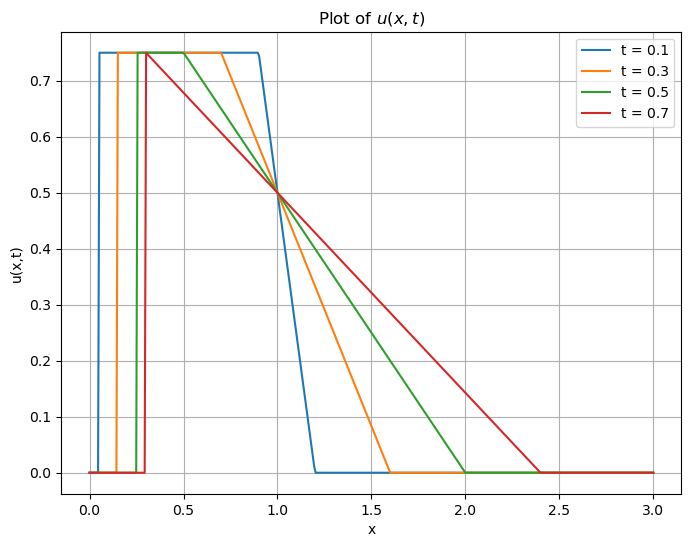

In [108]:
def u(x, t):
    x = np.asarray(x)  # Ensure x is an array

    if t == 0:
        return np.zeros_like(x)  # Avoid division by zero

    # Define the piecewise function u(x,t)
    condition1 = x <= 0.5 * t # not used because it is alreadu set to 0
    condition2 = (0.5 * t < x) & (x <= 1 - t)
    condition3 = (1 - t < x) & (x < 1 + 2 * t)
    condition4 = x >= 1 + 2 * t # not used because it is alreadu set to 0

    u_values = np.zeros_like(x)  # Initialize with zeros
    
    # Apply conditions
    u_values[condition2] = 3 / 4
    u_values[condition3] = 0.5 * (1 - (x[condition3]-1) / (2 * t + 1e-10))  # Avoid division by zero

    return u_values

# Define x and t values
x_values = np.linspace(0, 3, 400)
t_values = [0.1, 0.3, 0.5, 0.7]

# Plot for different values of t
plt.figure(figsize=(8, 6))
for t in t_values:
    u_values = u(x_values, t)
    plt.plot(x_values, u_values, label=f't = {t}')

plt.title(r'Plot of $u(x,t)$')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.grid(True)
plt.show()


*Numerical solution using Rusanov scheme:*

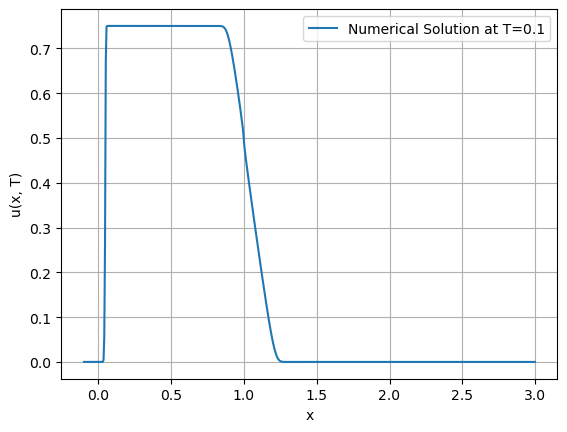

In [109]:
# Define flux function and its derivative
def flux(u):
    return 2 * u * (1 - u)

def flux_derivative(u):
    return 2 * (1 - 2 * u)

# Define initial conditions
def initial_condition(x):
    return np.where(x < 0, 0, np.where(x <= 1, 3/4, 0))

# Rusanov flux function
def rusanov_flux(ul, ur):
    f_ul = flux(ul)
    f_ur = flux(ur)
    max_speed = max(abs(flux_derivative(ul)), abs(flux_derivative(ur)))
    return 0.5 * (f_ul + f_ur) - 0.5 * max_speed * (ur - ul)

# Solve using the Rusanov scheme
def solve_rusanov(xmin, xmax, Nx, T, CFL=0.5):
    dx = (xmax - xmin) / Nx  # Space step
    x = np.linspace(xmin + dx/2, xmax - dx/2, Nx)  # Cell-centered grid
    u = initial_condition(x)  # Initial condition

    dt = CFL * dx / np.max(np.abs(flux_derivative(u)))  # Time step based on CFL
    Nt = int(T / dt)  # Number of time steps
    dt = T / Nt  # Adjust dt to match T exactly

    for _ in range(Nt):
        # Compute numerical flux using Rusanov's method
        f_half = np.zeros(Nx + 1)
        for i in range(Nx - 1):
            ul, ur = u[i], u[i+1]
            f_half[i+1] = rusanov_flux(ul, ur)

        # Update using finite volume method
        u[1:-1] -= dt / dx * (f_half[2:Nx] - f_half[1:Nx-1])

        # Apply boundary conditions (outflow)
        u[0] = u[1]
        u[-1] = u[-2]

    return x, u

# Define parameters
xmin, xmax = -0.1, 3
Nx = 600  # Number of grid points
T = 0.1  # Final time

# Solve the problem
x, u = solve_rusanov(xmin, xmax, Nx, T)

# Plot the solution
plt.plot(x, u, label=f"Numerical Solution at T={T}")
plt.xlabel("x")
plt.ylabel("u(x, T)")
#plt.title("Numerical Solution of the Riemann Problem using Rusanov Scheme")
plt.legend()
plt.grid()
plt.show()


*Different grids:*

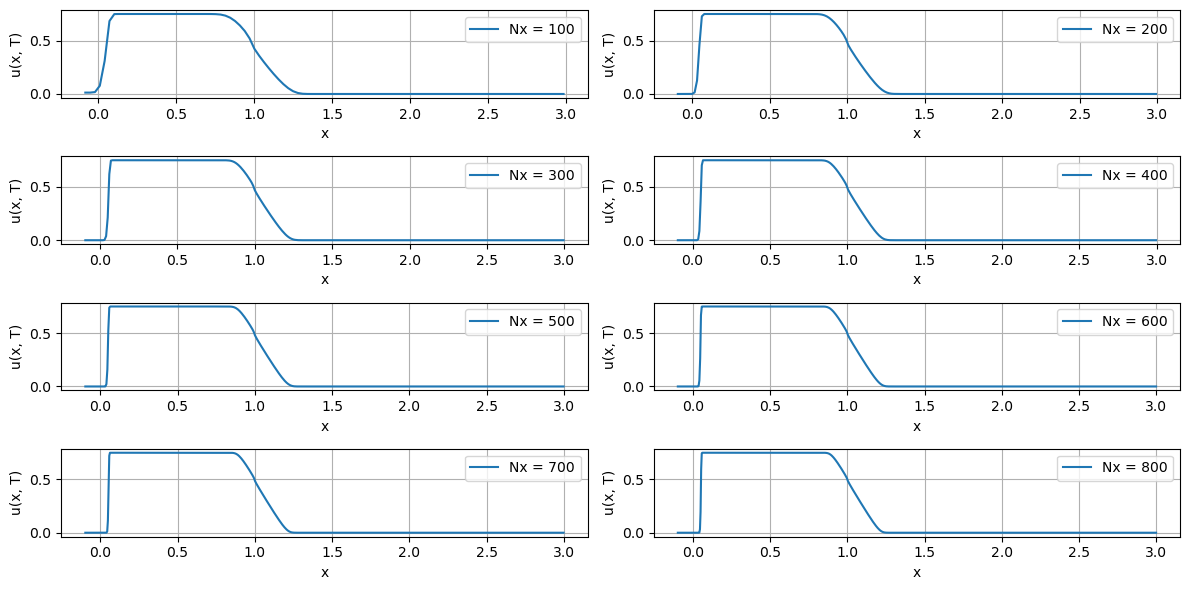

In [110]:
xmin, xmax = -0.1, 3
# Number of subplots
n_plots = 8  # Number of different Nx values to plot
fig, axes = plt.subplots(4,2, figsize=(12, 6))  # 2 rows, 4 columns

# Plot the solutions for different Nx in subplots
for idx, Nx in enumerate(range(100, 801, 100)):
    row = idx // 2  # Determine row index (0 or 1)
    col = idx % 2   # Determine column index (0 to 3)
    x, u = solve_rusanov(xmin, xmax, Nx, T)
    axes[row, col].plot(x, u, label=f"Nx = {Nx}")
    axes[row, col].set_xlabel("x")
    axes[row, col].set_ylabel("u(x, T)")
    axes[row, col].grid(True)
    axes[row, col].legend()

plt.tight_layout()  # Adjust subplots to fit nicely
plt.show()


Task 3 *a*  
#### The Density of Vehicles \( u(x,t) \) Over Time

The evolution of the vehicle density is governed by the equation:

$$
u_t + (u(1 - u))_x = 0
$$

with the initial condition:

$$
u_0(x) =
\begin{cases} 
0.2, & \text{if } x \in [-0.5,0] \\ 
0.4, & \text{if } x \in (0,0.5] \\ 
0.6, & \text{if } x \in (0.5,1.5] \\ 
0.8, & \text{if } x \in (1.5,2.5] \\ 
0.9, & \text{if } x \in (2.5,3.5]
\end{cases}
$$


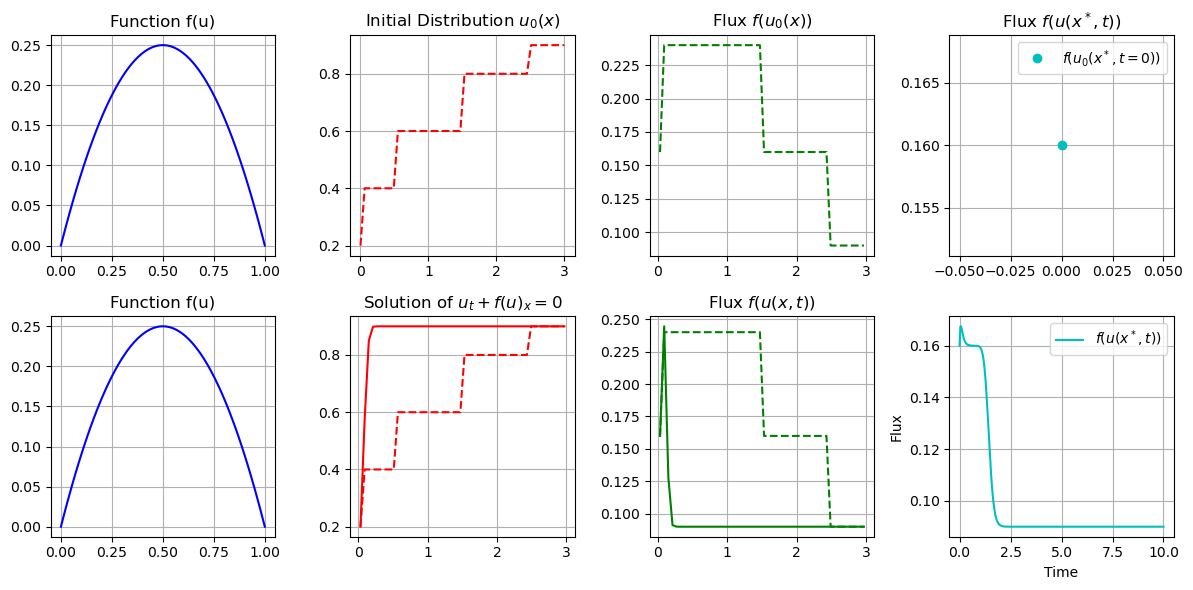

In [111]:
# Define flux function f(u)
def flux(u):
    return u * (1 - u)

# Define derivative of flux function f'(u)
def flux_derivative(u):
    return 1 - 2 * u  # f'(u) = 1 - 2u

# Define initial condition u_0(x)
def initial_condition(x):
    return np.piecewise(x, [(x >= -0.5) & (x <= 0), (x > 0) & (x <= 0.5),
                             (x > 0.5) & (x <= 1.5), (x > 1.5) & (x <= 2.5), 
                             (x > 2.5) & (x <= 3.5)], [0.2, 0.4, 0.6, 0.8, 0.9])

# Rusanov flux function
def rusanov_flux(ul, ur):
    f_ul, f_ur = flux(ul), flux(ur)
    max_speed = max(abs(flux_derivative(ul)), abs(flux_derivative(ur)))
    return 0.5 * (f_ul + f_ur) - 0.5 * max_speed * (ur - ul)

# Solve using the Rusanov scheme
def solve_rusanov(xmin, xmax, Nx, T, CFL=0.5):
    dx = (xmax - xmin) / Nx  # Space step
    x = np.linspace(xmin + dx / 2, xmax - dx / 2, Nx)  # Cell-centered grid
    u = initial_condition(x)  # Initial condition

    dt = CFL * dx / np.max(np.abs(flux_derivative(u)))  # Time step based on CFL
    Nt = int(T / dt)  # Number of time steps
    dt = T / Nt  # Adjust dt to match T exactly

    for _ in range(Nt):
        # Compute numerical flux using Rusanov's method
        f_half = np.zeros(Nx + 1)
        for i in range(Nx - 1):
            f_half[i + 1] = rusanov_flux(u[i], u[i + 1])

        # Update using finite volume method
        u[1:-1] -= dt / dx * (f_half[2:Nx] - f_half[1:Nx-1])

        # Apply boundary conditions (inflow at x=a, outflow at x=b)
        u[0] = 0.2  # Given boundary condition u_in
        u[-1] = u[-2]

    return x, u

# Plot results
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Flux function f(u)
u_values = np.linspace(0, 1, 100)
axes[0, 0].plot(u_values, flux(u_values), 'b', label='f(u)')
axes[1, 0].plot(u_values, flux(u_values), 'b', label='f(u)')
axes[0, 0].set_title('Function f(u)')
axes[1, 0].set_title('Function f(u)')
axes[0, 0].grid(True)
axes[1, 0].grid(True)

# Initial condition
xmin, xmax, Nx, T = 0, 3, 50, 10
x = np.linspace(xmin, xmax, Nx)
u0 = initial_condition(x)
axes[0, 1].plot(x, u0, 'r--', label='$u_0(x)$')
axes[0, 1].set_title('Initial Distribution $u_0(x)$')
axes[0, 1].grid(True)

# Solution at T=10
x, u_final = solve_rusanov(xmin, xmax, Nx, T)
axes[1, 1].plot(x, u0, 'r--', label='$u_0(x)$')
axes[1, 1].plot(x, u_final, 'r', label='$u(x,t)$')
axes[1, 1].set_title('Solution of $u_t + f(u)_x=0$')
axes[1, 1].grid(True)

# Flux function over space
axes[0, 2].plot(x, flux(u0), 'g--', label='$f(u_0(x))$')
axes[1, 2].plot(x, flux(u0), 'g--', label='$f(u_0(x))$')
axes[1, 2].plot(x, flux(u_final), 'g', label='$f(u(x,t))$')
axes[0, 2].set_title('Flux $f(u_0(x))$')
axes[1, 2].set_title('Flux $f(u(x,t))$')
axes[0, 2].grid(True)
axes[1, 2].grid(True)

# Solve and track flux evolution
def solve_rusanov_with_tracking(xmin, xmax, Nx, T, track_index=25):
    dx = (xmax - xmin) / Nx  
    x = np.linspace(xmin + dx / 2, xmax - dx / 2, Nx)
    u = initial_condition(x)

    dt = 0.5 * dx / np.max(np.abs(flux_derivative(u)))  
    Nt = int(T / dt)
    dt = T / Nt  

    tracked_u = []  

    for _ in range(Nt):
        tracked_u.append(u[track_index])  

        f_half = np.zeros(Nx + 1)
        for i in range(Nx - 1):
            f_half[i + 1] = rusanov_flux(u[i], u[i + 1])

        u[1:-1] -= dt / dx * (f_half[2:Nx] - f_half[1:Nx-1])

        u[0] = 0.2  
        u[-1] = u[-2]

    return x, u, np.array(tracked_u)  

xmin, xmax, Nx, T = 0, 3, 50, 10
x, u_final, tracked_u = solve_rusanov_with_tracking(xmin, xmax, Nx, T, track_index=25)

# Time vector
time_steps = np.linspace(0, T, len(tracked_u))

axes[0, 3].plot([0], [flux(tracked_u[0])], 'co', label='$f(u_0(x^*,t=0))$')
axes[1, 3].plot(time_steps, flux(tracked_u), 'c', label='$f(u(x^*,t))$')

axes[0, 3].set_title('Flux $f(u(x^*,t))$')
axes[1, 3].set_xlabel('Time')
axes[1, 3].set_ylabel('Flux')
axes[0, 3].grid(True)
axes[1, 3].grid(True)

axes[0, 3].legend()
axes[1, 3].legend()

plt.tight_layout()
plt.show()
